In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
# Bandit environment
class StationaryBandit:
    def __init__(self, k=10):
        self.k = k
        self.true_means = np.random.normal(0, 1, size=k)
        self.optimal_action = np.argmax(self.true_means)

    def pull(self, action):
        return np.random.normal(self.true_means[action], 1)

In [4]:
# Base class for algorithms
class BanditAlgorithm:
    def __init__(self, k):
        self.k = k
        self.counts = np.zeros(k)
        self.q_values = np.zeros(k)

    def update(self, action, reward):
        self.counts[action] += 1
        alpha = 1 / self.counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])

In [5]:
# 1. Greedy (non-optimistic)
class Greedy(BanditAlgorithm):
    def select_action(self):
        max_value = np.max(self.q_values)
        candidates = np.where(self.q_values == max_value)[0]
        return np.random.choice(candidates)

In [ ]:
# 2. Epsilon-greedy
class EpsilonGreedy(BanditAlgorithm):
    def __init__(self, k, epsilon):
        super().__init__(k)
        self.epsilon = epsilon

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        else:
            max_value = np.max(self.q_values)
            candidates = np.where(self.q_values == max_value)[0]
            return np.random.choice(candidates)

In [ ]:
# 3. Optimistic greedy
class OptimisticGreedy(BanditAlgorithm):
    def __init__(self, k, optimistic_value):
        super().__init__(k)
        self.q_values.fill(optimistic_value)

    def select_action(self):
        max_value = np.max(self.q_values)
        candidates = np.where(self.q_values == max_value)[0]
        return np.random.choice(candidates)

In [8]:
# 4. Gradient bandit
class GradientBandit:
    def __init__(self, k, alpha):
        self.k = k
        self.alpha = alpha
        self.preferences = np.zeros(k)
        self.avg_reward = 0
        self.step = 0

    def select_action(self):
        exp_prefs = np.exp(self.preferences)
        self.probs = exp_prefs / np.sum(exp_prefs)
        return np.random.choice(self.k, p=self.probs)

    def update(self, action, reward):
        self.step += 1
        self.avg_reward += (reward - self.avg_reward) / self.step
        for a in range(self.k):
            if a == action:
                self.preferences[a] += self.alpha * (reward - self.avg_reward) * (1 - self.probs[a])
            else:
                self.preferences[a] -= self.alpha * (reward - self.avg_reward) * self.probs[a]

In [ ]:
# Experiment runner
def run_experiment(algo_class, algo_args={}, n_steps=2000, n_runs=1000):
    rewards = np.zeros(n_steps)
    optimal_actions = np.zeros(n_steps)

    for run in range(n_runs):
        env = StationaryBandit()
        algo = algo_class(**algo_args)
        for t in range(n_steps):
            action = algo.select_action()
            reward = env.pull(action)
            algo.update(action, reward)
            rewards[t] += reward
            if action == env.optimal_action:
                optimal_actions[t] += 1

    rewards /= n_runs       #Average each 1000 simulations
    optimal_actions = 100 * optimal_actions / n_runs
    return rewards, optimal_actions

# Pilot run for epsilon-greedy
def pilot_test_epsilons(epsilons, n_runs=100, n_steps=500):
    plt.figure(figsize=(12, 6))
    for eps in epsilons:
        rewards, _ = run_experiment(EpsilonGreedy, {"k": 10, "epsilon": eps}, n_steps=n_steps, n_runs=n_runs)
        plt.plot(rewards, label=f"epsilon={eps}")
    plt.title("Pilot run: Average rewards for different epsilon values")
    plt.xlabel("Time Step")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

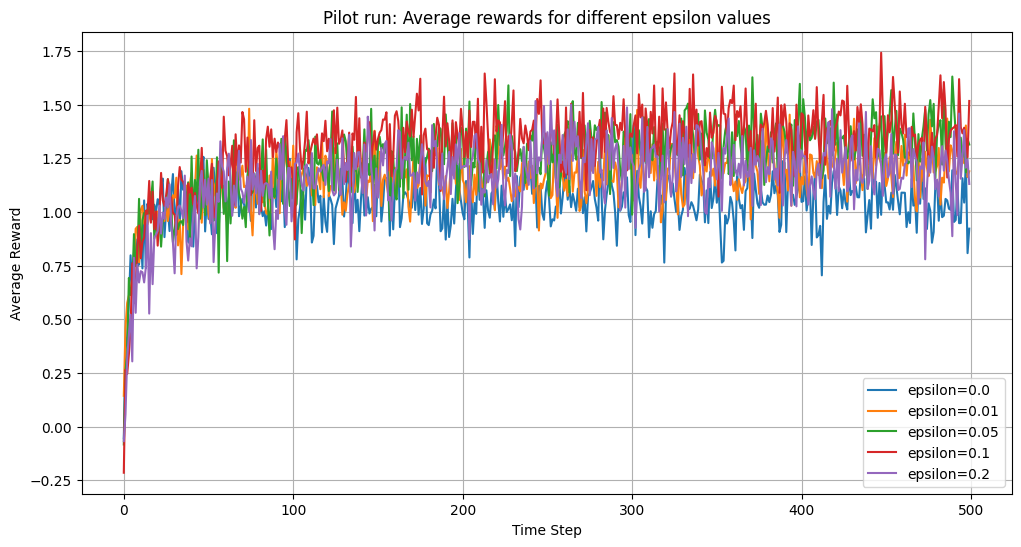

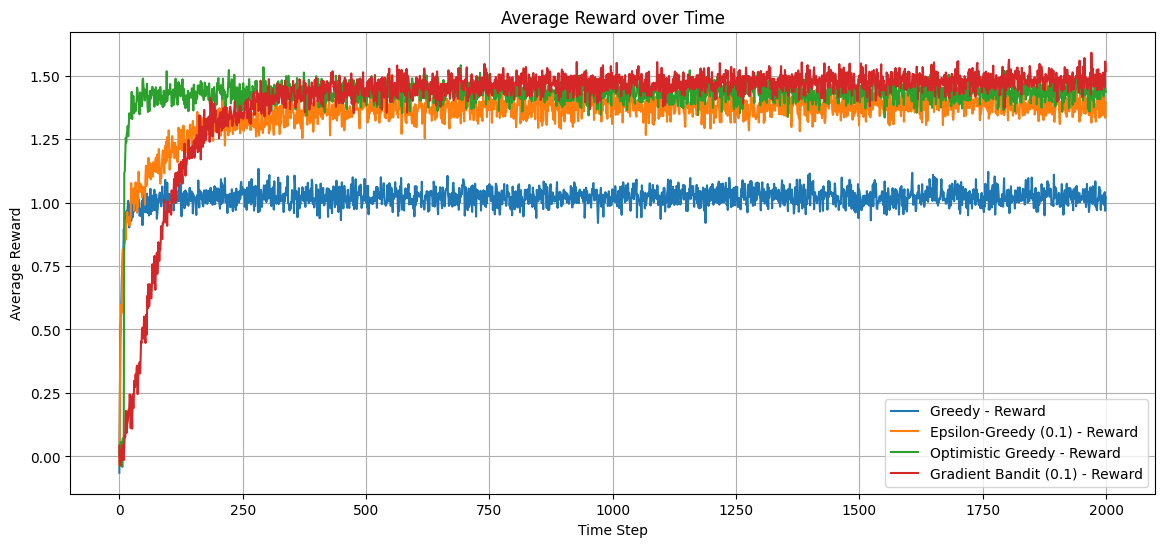

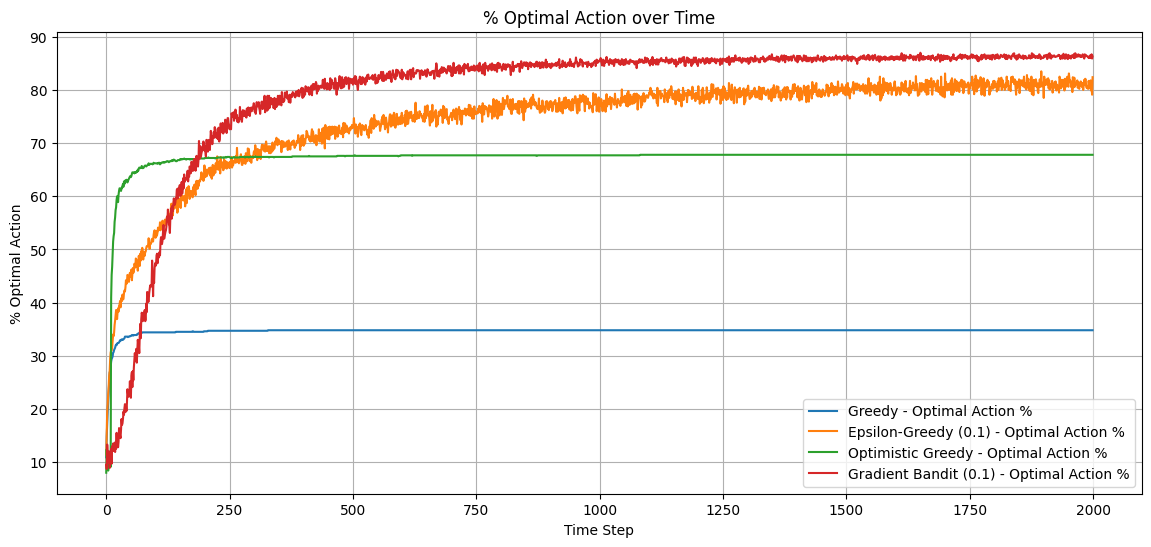

=== Summary Results at Final Timestep ===
Greedy: Avg Reward = 1.0430, Optimal Action % = 37.60%
Epsilon-Greedy (0.1): Avg Reward = 1.3420, Optimal Action % = 84.40%
Optimistic Greedy: Avg Reward = 1.4743, Optimal Action % = 71.40%
Gradient Bandit (0.1): Avg Reward = 1.4838, Optimal Action % = 86.90%


In [14]:
# Main
if __name__ == "__main__":
    k = 10
    mu_max = 2  # Reasonable upper bound for optimistic initialization
    optimistic_value = norm(loc=mu_max, scale=1).ppf(0.995)

    # Run pilot test for epsilon-greedy
    epsilons = [0.0, 0.01, 0.05, 0.1, 0.2]
    pilot_test_epsilons(epsilons, n_runs=100, n_steps=500)

    # Final experiments
    methods = [
                ("Greedy", Greedy, {"k": k}),
                ("Epsilon-Greedy (0.1)", EpsilonGreedy, {"k": k, "epsilon": 0.1}),
                ("Optimistic Greedy", OptimisticGreedy, {"k": k, "optimistic_value": optimistic_value}),
                ("Gradient Bandit (0.1)", GradientBandit, {"k": k, "alpha": 0.1})
            ]

    plt.figure(figsize=(14, 6))
    for name, algo_class, algo_args in methods:
        avg_rewards, _ = run_experiment(algo_class, algo_args)
        plt.plot(avg_rewards, label=f"{name} - Reward")

    plt.title("Average Reward over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(14, 6))
    for name, algo_class, algo_args in methods:
        _, optimal_acts = run_experiment(algo_class, algo_args)
        plt.plot(optimal_acts, label=f"{name} - Optimal Action %")
    plt.title("% Optimal Action over Time")
    plt.xlabel("Time Step")
    plt.ylabel("% Optimal Action")
    plt.legend()
    plt.grid()
    plt.show()


print("=== Summary Results at Final Timestep ===")
for name, algo_class, algo_args in methods:
    avg_rewards, optimal_acts = run_experiment(algo_class, algo_args)
    print(f"{name}: Avg Reward = {avg_rewards[-1]:.4f}, Optimal Action % = {optimal_acts[-1]:.2f}%")


# Part 2

In [15]:
class NonStationaryBandit:
    def __init__(self, k=10, seed=0, drift_type='drift'):
        self.k = k
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        # Initialize true means from N(0,1)
        self.mu_init = self.rng.normal(0, 1, size=k)
        self.mu = self.mu_init.copy()
        self.drift_type = drift_type
        self.kappa = 0.5
        self.sigma = np.sqrt(0.012)
        self.t = 0

    def step(self):
        # Update mus according to drift type
        noise = self.rng.normal(0, self.sigma, size=self.k)
        if self.drift_type == 'drift':
            self.mu = self.mu + noise
        elif self.drift_type == 'mean_reverting':
            self.mu = self.kappa * self.mu + noise
        else:
            raise ValueError("Unknown drift type")
        self.t += 1

    def permute_means(self, permutation):
        self.mu = self.mu[permutation]

    def pull(self, action):
        return self.rng.normal(self.mu[action], 1)


In [16]:
# Modify run_experiment to handle non-stationary environment with abrupt change and reset
def run_nonstationary_experiment(algo_class, algo_args={}, n_steps=2000, n_runs=1000,
                                drift_type='drift', abrupt_change=True, reset_at_change=False,
                                seeds=None, permutation=None):
    rewards = np.zeros(n_steps)
    optimal_actions = np.zeros(n_steps)

    # If no seeds provided, generate 10 fixed seeds for noise processes
    if seeds is None:
        seeds = np.arange(10)

    # If no permutation provided, generate one fixed permutation
    if permutation is None:
        rng_perm = np.random.default_rng(42)
        permutation = rng_perm.permutation(10)

    for run in range(n_runs):
        # Choose seed cyclically to ensure comparability
        seed = seeds[run % len(seeds)]
        env = NonStationaryBandit(k=10, seed=seed, drift_type=drift_type)
        algo = algo_class(**algo_args)
        for t in range(n_steps):
            if t > 0:
                env.step()

            # Abrupt change at t=501
            if abrupt_change and t == 501:
                env.permute_means(permutation)
                if reset_at_change:
                    # Hard reset: reset action values / preferences
                    if hasattr(algo, 'q_values'):
                        algo.q_values.fill(0)
                        algo.counts.fill(0)
                    if hasattr(algo, 'preferences'):
                        algo.preferences.fill(0)
                        algo.avg_reward = 0
                        algo.step = 0

            action = algo.select_action()
            reward = env.pull(action)
            algo.update(action, reward)

            rewards[t] += reward
            if action == np.argmax(env.mu):
                optimal_actions[t] += 1

    rewards /= n_runs
    optimal_actions = 100 * optimal_actions / n_runs
    return rewards, optimal_actions

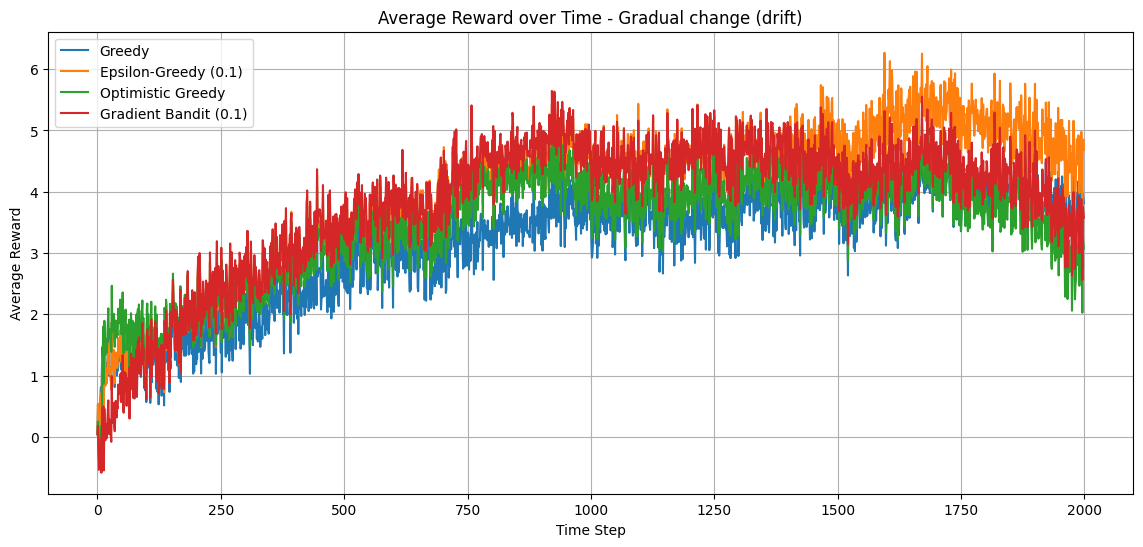

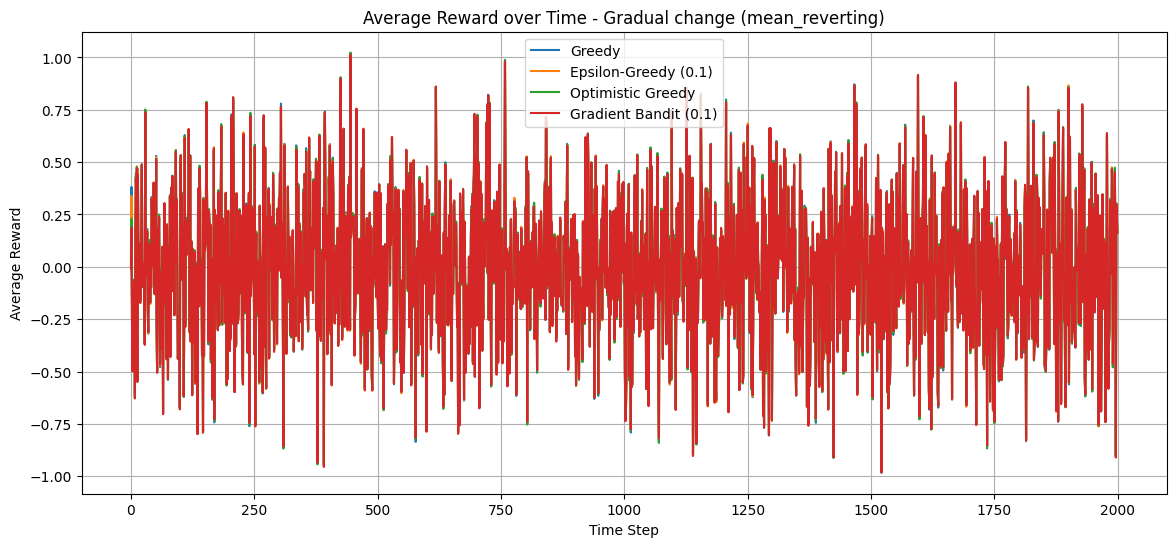

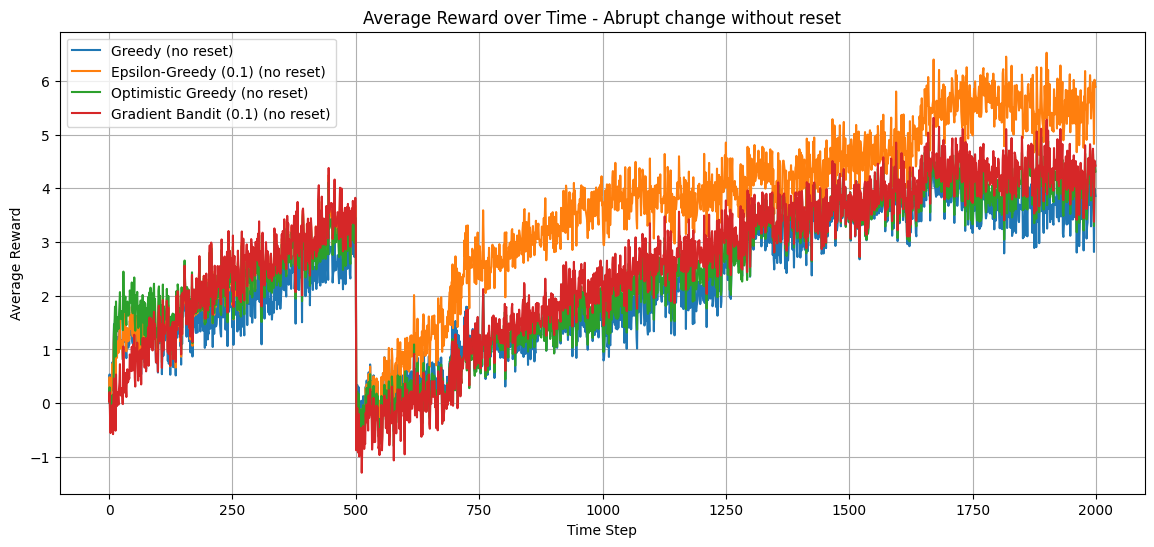

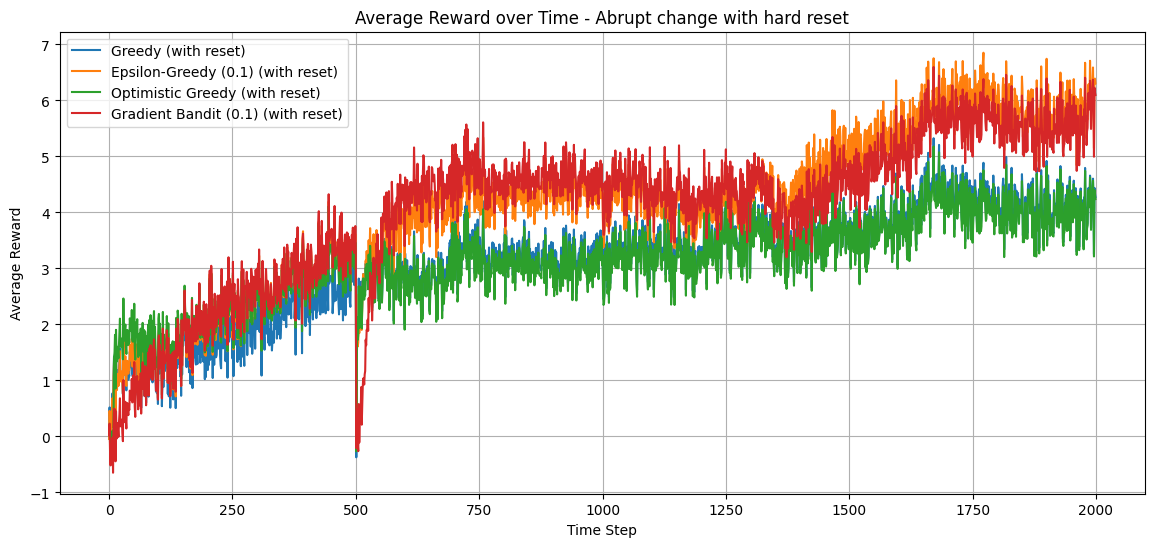

In [18]:
# Example usage for gradual drift and mean-reverting
if __name__ == "__main__":
    k = 10
    n_steps = 2000
    n_runs = 1000
    seeds = np.arange(10)  # fixed 10 seeds
    rng_perm = np.random.default_rng(42)
    permutation = rng_perm.permutation(k)

    methods = [
        ("Greedy", Greedy, {"k": k}),
        ("Epsilon-Greedy (0.1)", EpsilonGreedy, {"k": k, "epsilon": 0.1}),
        ("Optimistic Greedy", OptimisticGreedy, {"k": k, "optimistic_value": 2.5}),  # adjusted optimistic_value
        ("Gradient Bandit (0.1)", GradientBandit, {"k": k, "alpha": 0.1}),
    ]

    # 2.1 Drift gradual change test
    for drift_type in ['drift', 'mean_reverting']:
        plt.figure(figsize=(14,6))
        for name, algo_class, algo_args in methods:
            rewards, optimal_actions = run_nonstationary_experiment(
                algo_class, algo_args, n_steps, n_runs,
                drift_type=drift_type, abrupt_change=False,
                seeds=seeds, permutation=permutation)
            plt.plot(rewards, label=f"{name}")
        plt.title(f"Average Reward over Time - Gradual change ({drift_type})")
        plt.xlabel("Time Step")
        plt.ylabel("Average Reward")
        plt.legend()
        plt.grid()
        plt.show()

    # 2.2 Abrupt change test without reset
    plt.figure(figsize=(14,6))
    for name, algo_class, algo_args in methods:
        rewards, optimal_actions = run_nonstationary_experiment(
            algo_class, algo_args, n_steps, n_runs,
            drift_type='drift', abrupt_change=True, reset_at_change=False,
            seeds=seeds, permutation=permutation)
        plt.plot(rewards, label=f"{name} (no reset)")
    plt.title("Average Reward over Time - Abrupt change without reset")
    plt.xlabel("Time Step")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

    # 2.2 Abrupt change test with hard reset
    plt.figure(figsize=(14,6))
    for name, algo_class, algo_args in methods:
        rewards, optimal_actions = run_nonstationary_experiment(
            algo_class, algo_args, n_steps, n_runs,
            drift_type='drift', abrupt_change=True, reset_at_change=True,
            seeds=seeds, permutation=permutation)
        plt.plot(rewards, label=f"{name} (with reset)")
    plt.title("Average Reward over Time - Abrupt change with hard reset")
    plt.xlabel("Time Step")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()